In [35]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np

In [36]:
class World:
    def __init__(self, debug=False):
        self.objects = [] 
        self.debug = debug
        
    def append(self,obj):             # オブジェクトを登録するための関数
        self.objects.append(obj)
    
    def draw(self):
        fig = plt.figure(figsize=(4,4))                # 8x8 inchの図を準備
        ax = fig.add_subplot(111)                      # サブプロットを準備
        ax.set_aspect('equal')                         # 縦横比を座標の値と一致させる
        ax.set_xlim(-10,10)                              # X軸を-5m x 5mの範囲で描画
        ax.set_ylim(-10,10)                              # Y軸も同様に
        ax.set_xlabel("X",fontsize=10)                 # X軸にラベルを表示
        ax.set_ylabel("Y",fontsize=10)                 # 同じくY軸に
        
        elems = []
        
        if self.debug:        
            for i in range(1000): self.one_step(i, elems, ax) 
        else:
            self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax), frames=200, interval=1000, repeat=False)
            plt.show()
        
    def one_step(self, i, elems, ax):    ### fig:one_step_add_one_step 
        while elems: elems.pop().remove()
        elems.append(ax.text(-4.4, 4.5, "t = "+str(i), fontsize=10)) 
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"): obj.one_step(1.0)     # 追加

In [88]:

class IdealRobot:                         ### fig:rewrite_init_for_agent 
    def __init__(self, pose, agent=None, color="k"):  # agentという引数を追加
        self.pose = pose 
        self.r = 0.2 
        self.color = color 
        self.agent = agent   # 追加
        self.poses = [pose]         # 軌跡の描画用。追加
        self.time = 0
        self.odom = pose
   
    def draw(self, ax, elems):  ###idealrobot6draw
        x, y, theta = self.pose                   # 姿勢の変数を分解して3つの変数へ
        xn = x + self.r * math.cos(theta)         #  ロボットの鼻先のx座標 
        yn = y + self.r * math.sin(theta)         #  ロボットの鼻先のy座標 
        elems += ax.plot([x,xn], [y,yn], color=self.color) # ロボットの向きを示す線分の描画
        c = patches.Circle(xy=(x, y), radius=self.r, fill=False, color=self.color) 
        elems.append(ax.add_patch(c))   # 上のpatches.Circleでロボットの胴体を示す円を作ってサブプロットへ登録
        
        self.poses.append(self.pose) #以下追加。軌跡の描画
        elems += ax.plot([e[0] for e in self.poses], [e[1] for e in self.poses], linewidth=0.5, color="black")
            
    @classmethod
    def state_transition(cls, nu, omega, time, pose):    ### fig:state_transition(20-35行目)
        t0 = pose[2]
        if math.fabs(omega) < 1e-10:
            return pose + np.array( [nu*math.cos(t0), 
                                     nu*math.sin(t0),
                                     omega ] ) * time
        else:
            return pose + np.array( [nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)), 
                                     nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                                     omega*time ] )

    def one_step(self, time_interval):            ### fig:robot_one_step
        if not self.agent: return
        nu, omega = self.agent.decision(odom = self.odom)
        #print(nu, omega)
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        self.odom = self.state_transition(nu, omega, time_interval, self.odom)
        #print(self.odom)
        self.time = self.time + time_interval

In [91]:

class Agent:                        ### fig:Agent
    def __init__(self, nu, omega,trajs = None):
        self.nu = nu
        self.omega = omega
        self.trajs = trajs
    def decision(self, observation=None, odom = [0,0,0]):
    
        for ir in trajs:
            if ir.end is 0:
                print(ir.end_x)
                return ir.vector(odom)
        return 0,0 



class VectorAgent:
    def __init__(self, points):
        self.number = 0
        self.points = points
        self.vectors = []
        self.functions = []
        self.thetas = []
        for i in range(len(self.points.objects)-1):
            self.vectors.append([self.points.objects[i],self.points.objects[i+1]])
            self.functions.append(self.LinearFunction(self.vectors[i]))#self.funcitonsに　y=ax+b,x=cの[a,b,c]を格納
            self.thetas.append(self.theta(self.vectors[i]))
            
    def theta(self,vector):
        
        start_x = vector[0][0]
        start_y = vector[0][1]
        end_x = vector[1][0]
        end_y = vector[1][1]
        
        theta = math.atan2(end_y - start_y,end_x - start_x)
        return theta
            
    def LinearFunction(self,vector):#y =ax+b , x = c
        
        start_x = vector[0][0]
        start_y = vector[0][1]
        end_x = vector[1][0]
        end_y = vector[1][1]
        
        if (end_x - start_x) is 0:
            a = 0
            b = 0
            c = end_x
            return a,b,c
        
        else:
            a = (end_y - start_y)/(end_x - start_x)
            b = end_y - a * end_x
            c = 0
            
            return a,b,c
            
            
        
    # y=ax+b と (x,y)の距離(点が上右でプラス、下左でマイナス)
    def bias(self,a,b,c,x,y):
        if c is not 0:
            bias = x - c
            return bias
        else:
            bias = abs((a*x-y+b)/math.sqrt(1+pow(a,2)))
            if (a*x + b) < y:bias = -bias
            return bias
    
    def end_scope(self,vector,odom):#オドメトリの値がend付近に来たらTrueを返す
        end_x = vector[1][0]
        end_y = vector[1][1]
        scope = 0.7
        if (end_x-scope < odom[0] < end_x+scope)and(end_y-scope < odom[1] < end_y+scope):
            return True
        return False

    def decision(self, observation=None, odom = [0,0,0]):
        #print(self.number)
        if self.number < len(self.vectors):
            list_number = self.number
            if list_number > len(self.vectors):list_number = len(self.number) - 1
            print(list_number)
            if self.end_scope(self.vectors[list_number],odom):self.number = self.number + 1
            x = odom[0]
            y = odom[1]
            t = odom[2]
            t_ref = self.thetas[list_number]
        
            t_lim = 30/180*math.pi
            
        
            if -t_lim > (t_ref - t):return 0,-t_lim
            if t_lim < (t_ref - t):return 0,t_lim
            else:
                nu = 0.1
                omega = t_ref - t
                return nu, omega
        else: return 0,0
        
        
        
            
class Points:
    def __init__(self):
        self.objects = []
        
    def append(self,x,y):
        self.objects.append([x,y])
        

    

        
points = Points()
points.append(0,0)
points.append(5,1)
points.append(1,3)
points.append(5,3)

agent = VectorAgent(points)
print(agent.vectors)
print(agent.functions)


[[[0, 0], [5, 1]], [[5, 1], [1, 3]], [[1, 3], [5, 3]]]
[(0.2, 0.0, 0), (-0.5, 3.5, 0), (0.0, 3.0, 0)]


<IPython.core.display.Javascript object>


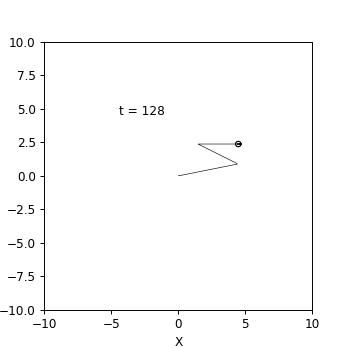

In [93]:
world = World(debug = False)         ### fig:rewrite_robot_for_agent   
points = [[0,0],[1,1]]
robot1 = IdealRobot( np.array([ 0, 0, 0]).T,agent = agent)  
world.append(robot1)

world.draw()